In [1]:
#%%  Import all the packages needed to explore grib data
import xarray as xr
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import cartopy.crs as ccrs
import cartopy

from pathlib  import Path

import sys
# insert path to src folder no matter from where the notebook is run
sys.path.insert(0, "..")

# import my stuff:
from src.plotting.plot_ens import (colors_ens, plot_ens_lineplot,get_country_record,
                                   plot_ens_tripleplot)
from src.data_loading.load_ens import (calculate_wind_speed,
                                       load_ens_data_ED, average_over_shape) 

# auto reload imports
%load_ext autoreload
%autoreload 2
#%% wider plots
# wider plots
plt.rcParams['figure.figsize'] = [10, 5]
from IPython.core.interactiveshell import InteractiveShell
# just the last output
InteractiveShell.ast_node_interactivity = "last_expr"
import warnings
warnings.filterwarnings('ignore')

# =======================================
#%% Flags and directories
## Flags and directories
# =========================================
load_full_D = True
drop_wind_components = True
calculate_diffs = True
save_fig = False

validate_function = False
if validate_function:
    from src.tests.test_functions import validate_function_average_over_shape

dir_data = Path('../data/ecmwf-ens')
fn_E = dir_data /"mars_v05e_2017-01-02_Mon.grib"
fn_D = dir_data /"mars_v05d_2017-01-02_Mon.grib"

dir_fig = Path('../report/figures')

latlon_vienna = (48.2082, 16.3738)


In [2]:
#%% Load the data
## Load the data
# =========================================
ds, dsD = load_ens_data_ED(fn_E, fn_D,
                           load_full_D=True,
                           drop_wind_components=True,
                           temperature_in_C=True,
                           calculate_diffs=True
                           )



2023-05-09 22:00:04,191 - INFO- Load - Loading ../data/ecmwf-ens/mars_v05e_2017-01-02_Mon.grib
2023-05-09 22:00:19,719 - INFO- Load - Loading ../data/ecmwf-ens/mars_v05d_2017-01-02_Mon.grib (full)
2023-05-09 22:01:54,376 - INFO- Load - Processing fields: wind temperature diffs 
2023-05-09 22:02:42,035 - INFO- Load - Loading complete


In [3]:
#%% print variables
## print variables
# =========================================
#print bold header and title
print("ECMWF ENS Extended data variables :\n")
print(f"{'var':6s} {'units':10s} {'long_name':30s}")
print("-"*50)
for v in ds.data_vars:
    # table format
    print(f"{v:6s} {ds[v].attrs['units']:10s} {ds[v].attrs['long_name']:30s}")
    
vars = ["t2m","d2m","stl4","ssrd","strd","w10","w100"]

ECMWF ENS Extended data variables :

var    units      long_name                     
--------------------------------------------------
sp     Pa         Surface pressure              
t2m    C          2 metre temperature           
ssrd   J m**-2/h  Δ Surface short-wave (solar) radiation downwards
strd   J m**-2/h  Δ Surface long-wave (thermal) radiation downwards
ssr    J m**-2/h  Δ Surface net short-wave (solar) radiation
ro     m          Runoff                        
stl4   C          Soil temperature level 4      
d2m    C          2 metre dewpoint temperature  
w10    m s**-1    10m wind speed                
w100   m s**-1    100m wind speed               


In [4]:
#%% Load the data
## Load the data
# =========================================
def calculate_variance(ds, vars=["t2m","d2m","stl4","ssrd","strd","w10","w100"],start_time=None):
    ds_var = ds[vars].resample(step="1D").mean().var(dim=["number"]
                        ).mean(["latitude","longitude"])
    if start_time==None:
        start_time=ds_var.time
    ds_var = ds_var.assign_coords(valid_time=ds_var.step+start_time)
    return ds_var
    
def extract_var(date, start_time=None):
    fn2_E = dir_data / f"mars_v0{date[0]}e{date[1:]}.grib"
    fn2_D = dir_data / f"mars_v0{date[0]}d{date[1:]}.grib"
    ds2, dsD2 = load_ens_data_ED(fn2_E, fn2_D,
                            load_full_D=True,
                            drop_wind_components=True,
                            temperature_in_C=True,
                            calculate_diffs=True
                            )

    #calculate variance over number latitude and longitude
    ds2_var = calculate_variance(ds2.isel(step=slice(None,269-121)
                            ), start_time=start_time)
    dsD2_var = calculate_variance(dsD2,start_time=start_time)
    del ds2, dsD2
    return ds2_var, dsD2_var

In [5]:

#calculate variance over number latitude and longitude
ds_var = calculate_variance(ds.isel(step=slice(None,269-121)))

dsD_var = calculate_variance(dsD)
dsD_var_max = dsD_var.max(dim="step")


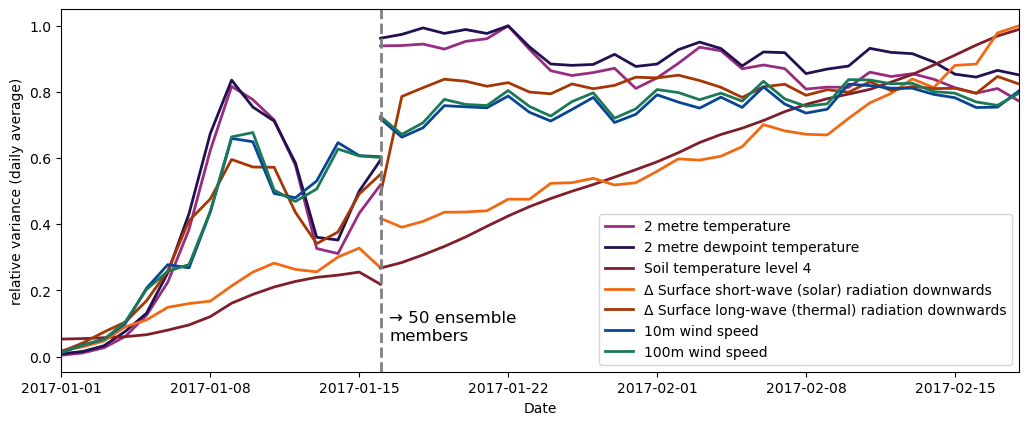

In [6]:
# Plot the variance for each variable as line plot
colors_dict = dict(t2m="#982d80",stl4="#801E29",d2m="#221150" ,ssrd="#f16913",strd="#a63603",w10="#084594",w100="#1c7958")
colors = [colors_dict[v] for v in vars]

fig,ax = plt.subplots(1,1,figsize=(21/1.7,8/1.7))
ax.set_prop_cycle(mpl.cycler(color=colors))
(ds_var/dsD_var_max).to_array(dim="variable").plot.line(x="valid_time", hue="variable", ax=ax, lw=2)
ax.set_prop_cycle(mpl.cycler(color=colors)) #reset color cycle for D data
(dsD_var/dsD_var_max).to_array(dim="variable").isel(step=slice(None,-1)).plot.line(x="valid_time", hue="variable", ax=ax, lw=2)

# set legend bottom right with long names
vars_long = [ds[v].long_name for v in vars]
ax.legend(loc="lower right", labels=vars_long)

ax.set_ylabel("relative variance (daily average)")
ax.set_xticklabels(ax.get_xticklabels(),rotation=0,ha="center")
date_range = ds.valid_time.values.min(), ds.valid_time.values.max()-pd.Timedelta("1D")

# set xticks to every 7 days starting at 2017-01-02
ax.set_xticks(pd.date_range(*date_range,freq="7D"))
ax.set_xlim(*date_range)

ax.set_title("")
ax.set_xlabel("Date")

# plot vertical grey dashed line before the first valid time of the D data
cutoff = dsD.valid_time[0].values
ax.axvline(cutoff, color="grey", linestyle="--", linewidth=2)
# add a small text right of this line "→ 50 ensemble members"
ax.text(cutoff + np.timedelta64(10, 'h'), 0.05, "→ 50 ensemble\nmembers", fontsize=12)

if save_fig:
    fig.savefig(dir_fig / "007_03_ens_var.png", dpi=300, bbox_inches="tight")

In [7]:
ds.valid_time.values.min(), ds.valid_time.values.max()

(numpy.datetime64('2017-01-02T00:00:00.000000000'),
 numpy.datetime64('2017-02-17T00:00:00.000000000'))

In [8]:
# dates= ["5_2017-01-05_Thu","5_2017-01-09_Mon",
#         "5_2017-01-12_Thu","5_2017-01-16_Mon",
#         "5_2017-01-19_Thu","5_2017-01-24_Mon",
#         "5_2017-01-05_Thu","5_2017-01-09_Mon"]
dates = ["5_2017-01-12_Thu","5_2017-01-16_Mon","5_2017-01-19_Thu"]

variances = [extract_var(date) for date in dates]

2023-05-09 22:03:04,182 - INFO- Load - Loading ../data/ecmwf-ens/mars_v05e_2017-01-12_Thu.grib
2023-05-09 22:03:18,565 - INFO- Load - Loading ../data/ecmwf-ens/mars_v05d_2017-01-12_Thu.grib (full)
2023-05-09 22:06:06,801 - INFO- Load - Processing fields: wind temperature diffs 
2023-05-09 22:07:18,962 - INFO- Load - Loading complete
2023-05-09 22:07:39,044 - INFO- Load - Loading ../data/ecmwf-ens/mars_v05e_2017-01-16_Mon.grib
2023-05-09 22:07:52,500 - INFO- Load - Loading ../data/ecmwf-ens/mars_v05d_2017-01-16_Mon.grib (full)
2023-05-09 22:09:56,358 - INFO- Load - Processing fields: wind temperature diffs 
2023-05-09 22:11:09,831 - INFO- Load - Loading complete
2023-05-09 22:11:42,549 - INFO- Load - Loading ../data/ecmwf-ens/mars_v05e_2017-01-19_Thu.grib
2023-05-09 22:12:00,171 - INFO- Load - Loading ../data/ecmwf-ens/mars_v05d_2017-01-19_Thu.grib (full)
2023-05-09 22:13:45,267 - INFO- Load - Processing fields: wind temperature diffs 
2023-05-09 22:14:38,598 - INFO- Load - Loading comp

In [9]:
def normalize_var(varE, varD):
    var_max = varD.max(dim="step")
    return varE/var_max, varD/var_max

In [10]:
ds

<xarray.Dataset>
Dimensions:              (number: 5, step: 269, latitude: 131, longitude: 157)
Coordinates:
  * number               (number) int64 1 2 3 4 5
    time                 datetime64[ns] 2017-01-02
  * step                 (step) timedelta64[ns] 00:00:00 ... 46 days 00:00:00
    surface              float64 0.0
  * latitude             (latitude) float64 72.0 71.7 71.4 ... 33.6 33.3 33.0
  * longitude            (longitude) float64 -12.0 -11.7 -11.4 ... 34.5 34.8
    valid_time           (step) datetime64[ns] 2017-01-02 ... 2017-02-17
    depthBelowLandLayer  float64 100.0
Data variables:
    sp                   (number, step, latitude, longitude) float32 1.019e+0...
    t2m                  (number, step, latitude, longitude) float32 -6.183 ....
    ssrd                 (number, step, latitude, longitude) float64 0.0 ... 0.0
    strd                 (number, step, latitude, longitude) float64 0.0 ... ...
    ssr                  (number, step, latitude, longitude) float64 0.0 ... 0.0
    ro                   (number, step, latitude, longitude) float32 0.0 ... ...
    stl4                 (number, step, latitude, longitude) float32 1.085 .....
    d2m                  (number, step, latitude, longitude) float32 -13.32 ....
    w10                  (number, step, latitude, longitude) float32 2.888 .....
    w100                 (number, step, latitude, longitude) float32 2.894 .....
Attributes:
    GRIB_edition:            1
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts
    history:                 2023-05-09T22:00 GRIB to CDM+CF via cfgrib-0.9.1...

In [11]:
pd.datetime(2016,12,21)-pd.datetime(2017,1,2)

datetime.timedelta(days=-12)

In [12]:
np.sin(np.pi/6*2/2)**4

0.06249999999999997

In [118]:
ds.latitude.mean()

<xarray.DataArray 'latitude' ()>
array(52.5)
Coordinates:
    time                 datetime64[ns] 2017-01-02
    surface              float64 0.0
    depthBelowLandLayer  float64 100.0

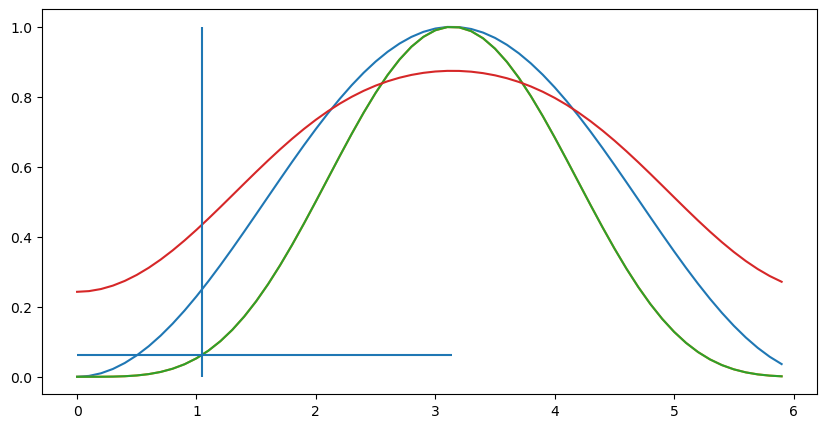

In [128]:
mean_latitude_radians = ds.latitude.mean().values*np.pi/180
axis_tilt_radians = 23.45*np.pi/180
func = lambda x: np.cos(mean_latitude_radians+axis_tilt_radians*np.cos(x))
x_mesh= np.arange(0,6,0.1)
plt.plot(x_mesh,(1-np.cos(x_mesh))/2)
plt.plot(x_mesh,(np.sin(x_mesh/2)**2)**2)
plt.plot(x_mesh,(np.sin(x_mesh/2)**2)**2)
plt.plot(x_mesh,func(x_mesh))
x_sample =np.pi/6*2
plt.vlines(x_sample,0,1)
plt.hlines(np.sin(x_sample/2)**4,0,np.pi)

In [14]:

period = pd.Timedelta("1Y").value


def offset_from_winter_solstice(time):
    '''for any date, returns the number of nanoseconds since the previous winter solstice, 
    for the purposes of plotting an accurate cosine of sun angle
    has to deal with solstice being in the previous year
    time: numpy.datetime64'''
    time = pd.to_datetime(time)
    solstice = pd.to_datetime(f"{time.year}-12-21")
    if time<solstice:
        solstice = pd.to_datetime(f"{time.year-1}-12-21")
    return (time-solstice).value
offset = offset_from_winter_solstice(ds.time.values)

In [15]:
steps_daily=dsD.step.isel(step=slice(None,269-121)
                            ).resample(step="1D").mean().values.astype(float)[:-1]
# daily nanosecond values for a whole year
steps_all = np.arange(-offset,-offset+period,pd.Timedelta("1D").value).astype(float)

In [62]:
date_strings = ["5_2017-01-30_Mon","5_2017-03-02_Thu",
         "5_2017-05-01_Mon","5_2017-07-03_Mon",
         "5_2017-09-04_Mon","5_2017-11-02_Thu"]
dsD_var_list = [ extract_var(date_str)[1] for date_str in date_strings]


2023-05-09 23:53:39,982 - INFO- Load - Loading ../data/ecmwf-ens/mars_v05e_2017-05-01_Mon.grib
2023-05-09 23:54:14,924 - INFO- Load - Loading ../data/ecmwf-ens/mars_v05d_2017-05-01_Mon.grib (full)
2023-05-09 23:58:01,602 - INFO- Load - Processing fields: wind temperature diffs 
2023-05-09 23:58:54,172 - INFO- Load - Loading complete


In [109]:
def get_steps(var_ds, origin_time=np.datetime64('2017-01-02')):
    return (var_ds.step.values.astype(float) + (var_ds.time - origin_time).values.astype(float))[1:]
def plot_var(var_ds,ax):
    steps_daily = get_steps(var_ds)
    ax = ax.plot(steps_daily,var_ds.ssrd[:-1],label=var_ds.time.values.astype("datetime64[D]"))
    return ax

In [166]:
### Fit sinusoidal functions to the data

    

def func2(x):
    return np.sin(x*np.pi)**2
def func3(x):
    return np.abs(np.sin(x*np.pi))**3
def func4(x):
    return np.sin(x*np.pi)**4

# Tilt of axis functions
def func_insol(x):
    mean_latitude_radians = ds.latitude.mean().values*np.pi/180
    axis_tilt_radians = 23.45*np.pi/180
    return np.cos(mean_latitude_radians+axis_tilt_radians*np.cos(2*np.pi*x))

def func_insol_var(x):
    mean_latitude_radians = ds.latitude.mean().values*np.pi/180
    axis_tilt_radians = 23.45*np.pi/180
    return np.cos(mean_latitude_radians+axis_tilt_radians*np.cos(2*np.pi*x))**2

# random other latitude (60 degrees works well)
def func_insol_var_lat(x, lat=60):
    latitude_radians = lat*np.pi/180
    axis_tilt_radians = 23.45*np.pi/180
    return np.cos(latitude_radians+axis_tilt_radians*np.cos(2*np.pi*x))**2

# properly integrated function (ignoring polar night)
def func_insol_var_integrated(x):
    min_latitude_radians = ds.latitude.min().values*np.pi/180
    max_latitude_radians = ds.latitude.max().values*np.pi/180
    A=min_latitude_radians
    B=max_latitude_radians
    axis_tilt_radians = 23.45*np.pi/180
    D=axis_tilt_radians*np.cos(2*np.pi*x)
    return 1/(4*(B-A))*(-np.sin(2*(A+D))+np.sin(2*(B+D)))+1/2

# fully integrated function (with polar night)
def func_insol_var_integrated_full(x):
    axis_tilt_radians = 23.45*np.pi/180
    latitudes = ds.latitude.values
    lat_radians = np.deg2rad(latitudes)
    
    insol_values = np.cos(lat_radians[:, None] + axis_tilt_radians * np.cos(2 * np.pi * x))**2
    insol_values[insol_values < 0] = 0
    
    return np.sum(insol_values, axis=0) / len(latitudes)



steps = steps_all
max_var = dsD_var.ssrd[:-1].max().values
# amplitude = max_var

var_datasets = [dsD_var]+dsD_var_list
y_data = np.concatenate([ds.ssrd[:-1].values for ds in var_datasets])
x_data = np.concatenate([get_steps(ds) for ds in var_datasets])

# Compute the sinusoidal function values for x_data
X2 = func((x_data + offset) / period)
X3 = func3((x_data + offset) / period)
X4 = func4((x_data + offset) / period)
# X_insol = func_insol((x_data + offset) / period)
X_insol_var = func_insol_var((x_data + offset) / period)
X_insol_var_lat = func_insol_var_lat((x_data + offset) / period)
X_insol_var_integrated = func_insol_var_integrated((x_data + offset) / period)
X_insol_var_integrated_full = func_insol_var_integrated_full((x_data + offset) / period)


# Compute the slope (k) using the least-squares method
k2 = np.dot(X2, y_data) / np.dot(X2, X2)
k3 = np.dot(X3, y_data) / np.dot(X3, X3)
k4 = np.dot(X4, y_data) / np.dot(X4, X4)
# k_insol = np.dot(X_insol, y_data) / np.dot(X_insol, X_insol)
k_insol_var = np.dot(X_insol_var, y_data) / np.dot(X_insol_var, X_insol_var)
k_insol_var_lat = np.dot(X_insol_var_lat, y_data) / np.dot(X_insol_var_lat, X_insol_var_lat)
k_insol_var_integrated = np.dot(X_insol_var_integrated, y_data) / np.dot(X_insol_var_integrated, X_insol_var_integrated)
# k_insol_var_integrated_full = np.dot(X_insol_var_integrated_full, y_data) / np.dot(X_insol_var_integrated_full, X_insol_var_integrated_full)


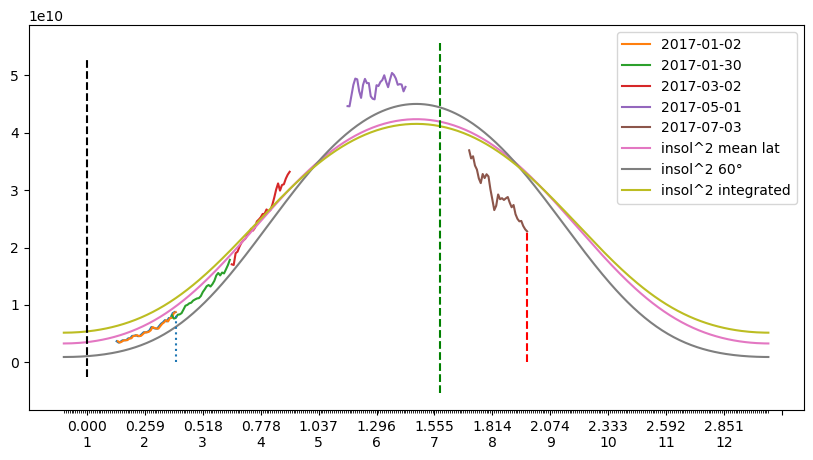

In [180]:
fig,ax = plt.subplots()

funcs = [func2, func3, func4]
def sin_norm(x, func):
    return func((x + offset) / period)
# plt.plot(dsD.step,dsD.ssrd.isel(number=1).sel(latitude=latlon_vienna[0],longitude=latlon_vienna[1],method="nearest"))
ax.plot(steps_daily,dsD_var.ssrd[:-1])
plot_var(dsD_var,ax)
for dsDi_var in dsD_var_list:
    plot_var(dsDi_var,ax)

# ax.plot(steps,sin_norm(steps,func2)*k2, label="sin^2")
# ax.plot(steps,sin_norm(steps,func3)*k3, label="sin^3")
# ax.plot(steps,sin_norm(steps,func4)*k4, label="sin^4")
ax.plot(steps,sin_norm(steps,func_insol_var)*k_insol_var, label="insol^2 mean lat")
ax.plot(steps,sin_norm(steps,func_insol_var_lat)*k_insol_var_lat, label=f"insol^2 {func_insol_var_lat.__defaults__[0]}°")
ax.plot(steps,sin_norm(steps,func_insol_var_integrated)*k_insol_var_integrated, label="insol^2 integrated")
# ax.plot(steps,sin_norm(steps,func_insol_var_integrated_full)*k_insol_var_integrated_full, label="insol^2 integrated full")
ax.vlines(ds.step.max(),0,max_var, linestyles=":")
ax.vlines(0,ax.get_ylim()[0],ax.get_ylim()[1],"k",linestyles="--")

# set minor xticks to steps_all
ax.set_xticks(steps_all,minor=True)
# set major tickes to the months in nano seconds since beginning of year
ax.set_xticks(np.arange(0,period,pd.Timedelta("30D").value),minor=False)

# add a second line of xlables with the month numbers keeping the previous labels
ticklabels = ax.get_xticklabels()
# two lines of labels
new_ticklabels = [f"{label.get_text()}\n{i+1}" for i,label in enumerate(ticklabels) if i!=12] +[""]
ax.set_xticklabels(new_ticklabels)

ax.legend()
#set xlim between -offset and -offset+period
# plt.xlim(-offset,-offset+period)

### STRD

In [199]:
def get_steps(var_ds, origin_time=np.datetime64('2017-01-02')):
    return (var_ds.step.values.astype(float) + (var_ds.time - origin_time).values.astype(float))[1:]
def plot_var(var_ds,ax):
    steps_daily = get_steps(var_ds)
    ax = ax.plot(steps_daily,var_ds.strd[:-1],label=var_ds.time.values.astype("datetime64[D]"))
    return ax

In [200]:
### Fit sinusoidal functions to the data

    

def func_insol_var(x):
    mean_latitude_radians = ds.latitude.mean().values*np.pi/180
    axis_tilt_radians = 23.45*np.pi/180
    return np.cos(mean_latitude_radians+axis_tilt_radians*np.cos(2*np.pi*x))**2

# random other latitude (60 degrees works well)
def func_insol_var_lat(x, lat=60):
    latitude_radians = lat*np.pi/180
    axis_tilt_radians = 23.45*np.pi/180
    return np.cos(latitude_radians+axis_tilt_radians*np.cos(2*np.pi*x))**2

# properly integrated function (ignoring polar night)
def func_insol_var_integrated(x):
    min_latitude_radians = ds.latitude.min().values*np.pi/180
    max_latitude_radians = ds.latitude.max().values*np.pi/180
    A=min_latitude_radians
    B=max_latitude_radians
    axis_tilt_radians = 23.45*np.pi/180
    D=axis_tilt_radians*np.cos(2*np.pi*x)
    return 1/(4*(B-A))*(-np.sin(2*(A+D))+np.sin(2*(B+D)))+1/2


steps = steps_all
max_var = dsD_var.ssrd[:-1].max().values
# amplitude = max_var

var_datasets = [dsD_var]+dsD_var_list
y_data = np.concatenate([ds.strd[:-1].values for ds in var_datasets])
x_data = np.concatenate([get_steps(ds) for ds in var_datasets])

# Compute the sinusoidal function values for x_data
X_insol_var = func_insol_var((x_data + offset) / period)
X_insol_var_lat = func_insol_var_lat((x_data + offset) / period)
X_insol_var_integrated = func_insol_var_integrated((x_data + offset) / period)


# Compute the slope (k) using the least-squares method

k_insol_var = np.dot(X_insol_var, y_data) / np.dot(X_insol_var, X_insol_var)
k_insol_var_lat = np.dot(X_insol_var_lat, y_data) / np.dot(X_insol_var_lat, X_insol_var_lat)
k_insol_var_integrated = np.dot(X_insol_var_integrated, y_data) / np.dot(X_insol_var_integrated, X_insol_var_integrated)

NameError: name 'dsD_var_list' is not defined

NameError: name 'dsD_var_list' is not defined

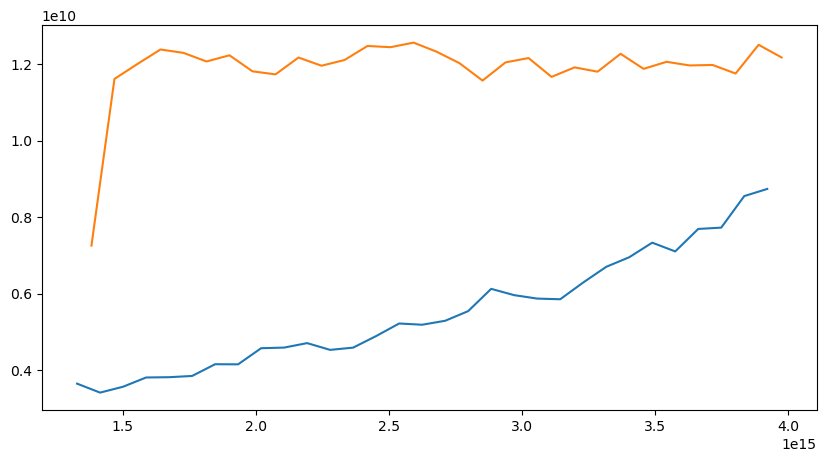

In [201]:
fig,ax = plt.subplots()

def sin_norm(x, func):
    return func((x + offset) / period)

ax.plot(steps_daily,dsD_var.ssrd[:-1])
plot_var(dsD_var,ax)
for dsDi_var in dsD_var_list:
    plot_var(dsDi_var,ax)

ax.plot(steps,sin_norm(steps,func_insol_var)*k_insol_var, label="insol^2 mean lat")
ax.plot(steps,sin_norm(steps,func_insol_var_lat)*k_insol_var_lat, label=f"insol^2 {func_insol_var_lat.__defaults__[0]}°")
ax.plot(steps,sin_norm(steps,func_insol_var_integrated)*k_insol_var_integrated, label="insol^2 integrated")
# ax.plot(steps,sin_norm(steps,func_insol_var_integrated_full)*k_insol_var_integrated_full, label="insol^2 integrated full")
ax.vlines(ds.step.max(),0,max_var, linestyles=":")
ax.vlines(0,ax.get_ylim()[0],ax.get_ylim()[1],"k",linestyles="--")

# set minor xticks to steps_all
ax.set_xticks(steps_all,minor=True)
# set major tickes to the months in nano seconds since beginning of year
ax.set_xticks(np.arange(0,period,pd.Timedelta("30D").value),minor=False)

# add a second line of xlables with the month numbers keeping the previous labels
ticklabels = ax.get_xticklabels()
# two lines of labels
new_ticklabels = [f"{label.get_text()}\n{i+1}" for i,label in enumerate(ticklabels) if i!=12] +[""]
ax.set_xticklabels(new_ticklabels)

ax.legend()
#set xlim between -offset and -offset+period
# plt.xlim(-offset,-offset+period)

## Corrected Solar Variance plot

In [183]:
ds_var.valid_time

<xarray.DataArray 'valid_time' (step: 16)>
array(['2017-01-02T00:00:00.000000000', '2017-01-03T00:00:00.000000000',
       '2017-01-04T00:00:00.000000000', '2017-01-05T00:00:00.000000000',
       '2017-01-06T00:00:00.000000000', '2017-01-07T00:00:00.000000000',
       '2017-01-08T00:00:00.000000000', '2017-01-09T00:00:00.000000000',
       '2017-01-10T00:00:00.000000000', '2017-01-11T00:00:00.000000000',
       '2017-01-12T00:00:00.000000000', '2017-01-13T00:00:00.000000000',
       '2017-01-14T00:00:00.000000000', '2017-01-15T00:00:00.000000000',
       '2017-01-16T00:00:00.000000000', '2017-01-17T00:00:00.000000000'],
      dtype='datetime64[ns]')
Coordinates:
    time                 datetime64[ns] 2017-01-02
    surface              float64 0.0
    depthBelowLandLayer  float64 100.0
  * step                 (step) timedelta64[ns] 0 days 1 days ... 15 days
    valid_time           (step) datetime64[ns] 2017-01-02 ... 2017-01-17

In [197]:

ds_var_corrected = ds_var.copy()
ds_var_phase = (offset_from_winter_solstice(ds_var_corrected.time.values)+ds_var_corrected.step).astype('float')/period
ds_var_corrected["ssrd"] = ds_var_corrected.ssrd/ds_var_phase
ds_var_corrected["strd"]= ds_var_corrected.strd/ds_var_phase
dsD_var_corrected = dsD_var.copy()
dsD_var_phase = (offset_from_winter_solstice(dsD_var_corrected.time.values)+dsD_var_corrected.step).astype('float')/period
dsD_var_corrected["ssrd"]= dsD_var_corrected.ssrd/dsD_var_phase
dsD_var_corrected["strd"]= dsD_var_corrected.strd/dsD_var_phase   
dsD_var_max = dsD_var_corrected.max(dim="step")


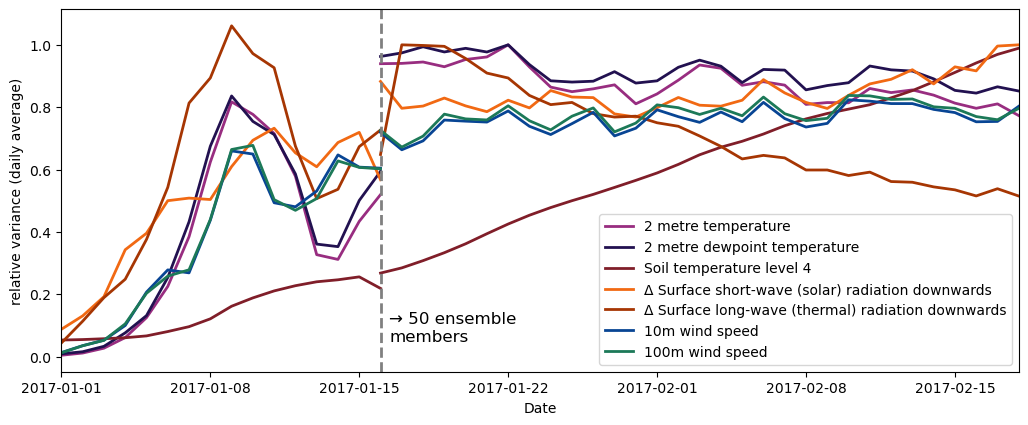

In [198]:
# Plot the variance for each variable as line plot
colors_dict = dict(t2m="#982d80",stl4="#801E29",d2m="#221150" ,ssrd="#f16913",strd="#a63603",w10="#084594",w100="#1c7958")
colors = [colors_dict[v] for v in vars]

fig,ax = plt.subplots(1,1,figsize=(21/1.7,8/1.7))
ax.set_prop_cycle(mpl.cycler(color=colors))
(ds_var_corrected/dsD_var_max).to_array(dim="variable").plot.line(x="valid_time", hue="variable", ax=ax, lw=2)
ax.set_prop_cycle(mpl.cycler(color=colors)) #reset color cycle for D data
(dsD_var_corrected/dsD_var_max).to_array(dim="variable").isel(step=slice(None,-1)).plot.line(x="valid_time", hue="variable", ax=ax, lw=2)

# set legend bottom right with long names
vars_long = [ds[v].long_name for v in vars]
ax.legend(loc="lower right", labels=vars_long)

ax.set_ylabel("relative variance (daily average)")
ax.set_xticklabels(ax.get_xticklabels(),rotation=0,ha="center")
date_range = ds.valid_time.values.min(), ds.valid_time.values.max()-pd.Timedelta("1D")

# set xticks to every 7 days starting at 2017-01-02
ax.set_xticks(pd.date_range(*date_range,freq="7D"))
ax.set_xlim(*date_range)

ax.set_title("")
ax.set_xlabel("Date")

# plot vertical grey dashed line before the first valid time of the D data
cutoff = dsD.valid_time[0].values
ax.axvline(cutoff, color="grey", linestyle="--", linewidth=2)
# add a small text right of this line "→ 50 ensemble members"
ax.text(cutoff + np.timedelta64(10, 'h'), 0.05, "→ 50 ensemble\nmembers", fontsize=12)

if save_fig:
    fig.savefig(dir_fig / "008_04_ens_var_corrected_solar.png", dpi=300, bbox_inches="tight")